In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from somda_project.helpers import lineplot 
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from datetime import datetime,timedelta
import json
from scipy.stats import pearsonr
from somda_project.data import wikicode_translations

In [2]:
df = pd.read_csv("data/merged_election_pages.csv", parse_dates=['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], format="mixed")
df.index = df["timestamp"]
df.fillna(df.mode().iloc[0], inplace=True)

In [3]:
f = open('./data/eu_elections.json')
election_data = json.load(f)

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format="mixed")
df = df.groupby(['wikicode', pd.Grouper(key='timestamp', freq='D')]).sum().reset_index(level='wikicode')
df[df["wikicode"] == "cs"].head()

,wikicode,hourly_views
timestamp,,
2009-05-21,cs,168.0
2009-05-22,cs,99.0
2009-05-23,cs,64.0
2009-05-24,cs,134.0
2009-05-25,cs,182.0


In [5]:
df.rename(columns={'hourly_views': 'views'}, inplace=True)
scaler = MinMaxScaler()
df['views_norm'] = df.groupby([df.index.year, 'wikicode'])['views'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
pivot_df = df.pivot_table(index='timestamp', columns='wikicode', values='views_norm')
pivot_df_abs = df.pivot_table(index='timestamp', columns='wikicode', values='views')
pivot_df_abs = pivot_df_abs.rename(columns=wikicode_translations)
pivot_df = pivot_df.rename(columns=wikicode_translations)
for column in pivot_df.columns:
    pivot_df[column] = scaler.fit_transform(pivot_df[column].values.reshape(-1, 1))


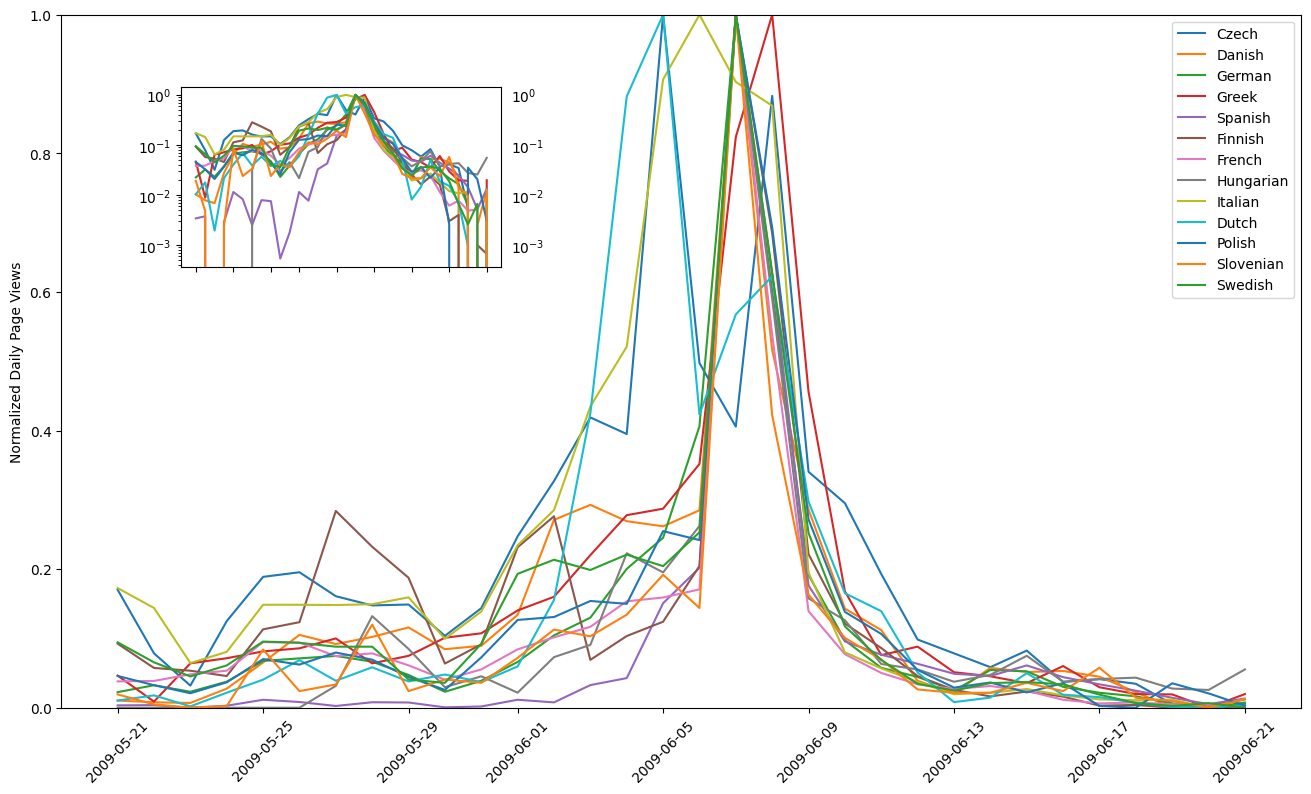

In [6]:
fig, ax1 = plt.subplots(figsize=(16, 9))
lineplot(pivot_df[pivot_df.index.year == 2009], ax1, show_inset=True, fig=fig)
plt.savefig('./report/fig/lineplot_2009.png')

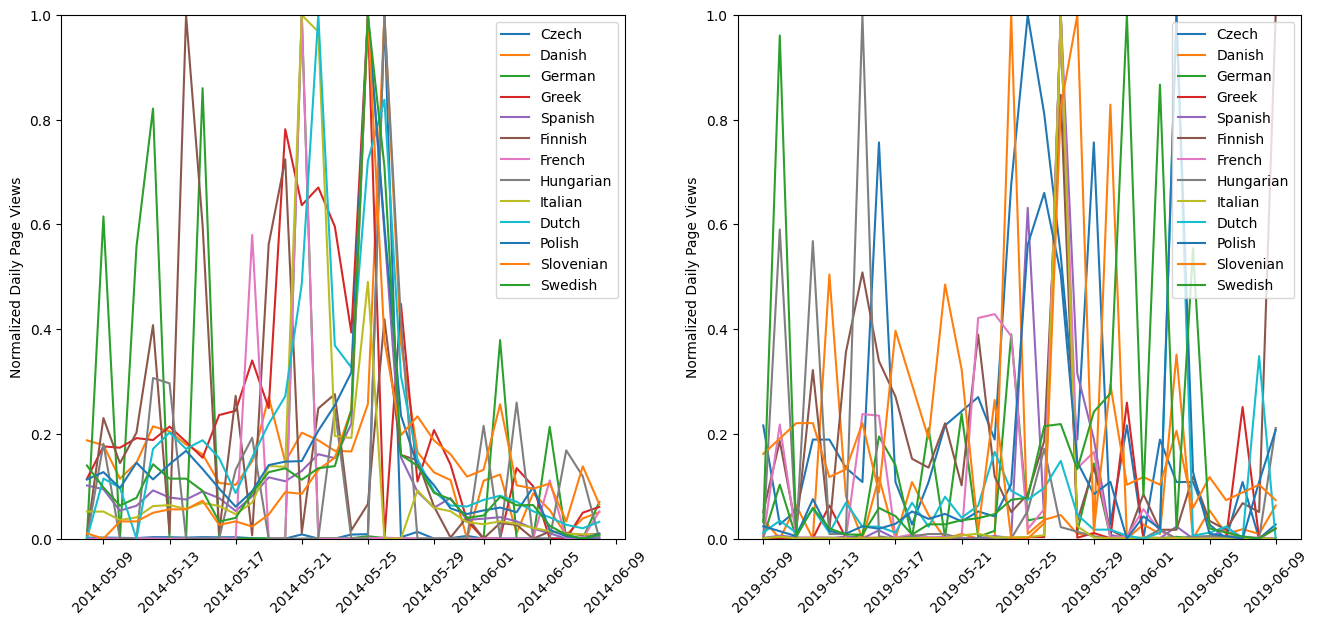

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6.8))
lineplot(pivot_df[pivot_df.index.year == 2014], ax1)
lineplot(pivot_df[pivot_df.index.year == 2019], ax2)
plt.savefig('./report/fig/lineplot_2014_2019.png')
plt.show()

In [8]:
nan_counts = pivot_df.groupby(pivot_df.index.year).apply(lambda x: x.isna().sum())
print(nan_counts)
zero_counts = pivot_df.groupby(pivot_df.index.year).apply(lambda x: x.eq(0).sum())
print("\n Zero counts: \n", zero_counts)

wikicode   Czech  Danish  German  Greek  Spanish  Finnish  French  Hungarian  \
timestamp                                                                      
2009           0       0       0      0        0        0       0          0   
2014           0       0       0      0        0        0       0          0   
2019           0       0       0      0        0        0       0          0   

wikicode   Italian  Dutch  Polish  Slovenian  Swedish  
timestamp                                              
2009             0      0       0          0        0  
2014             0      0       0          0        0  
2019             0      0       0          0        0  

 Zero counts: 
 wikicode   Czech  Danish  German  Greek  Spanish  Finnish  French  Hungarian  \
timestamp                                                                      
2009           1       1       1      1        1        1       1          6   
2014           3       1       3      4        1        1     

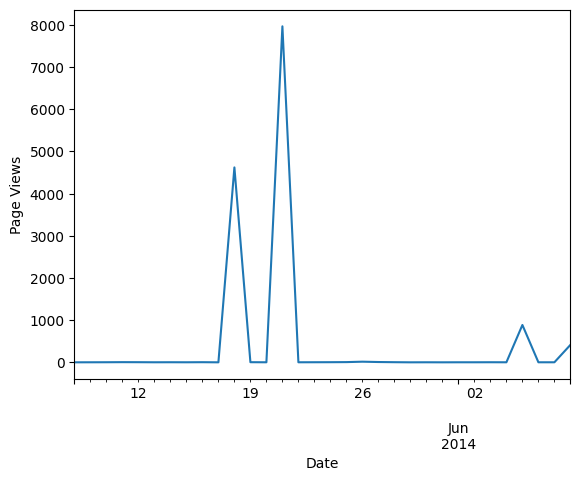

<Figure size 640x480 with 0 Axes>

In [28]:
# visualize outlier

import matplotlib.pyplot as plt

# Plot the data
pivot_df_abs["French"][pivot_df_abs.index.year == 2014].plot()

# Add labels
plt.xlabel("Date")
plt.ylabel("Page Views")

# Show the plot
plt.show()
# add label
plt.savefig('./report/fig/lineplot_hu.png')

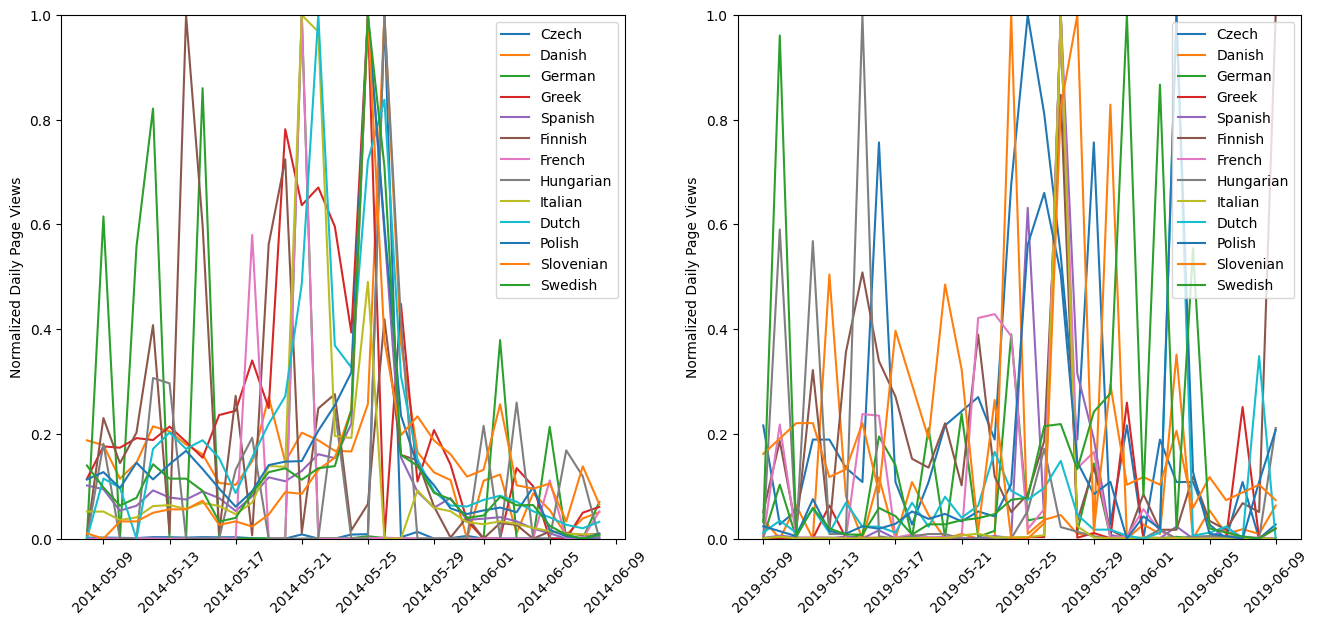

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6.8))
lineplot(pivot_df[pivot_df.index.year == 2014], ax1)
lineplot(pivot_df[pivot_df.index.year == 2019], ax2)
plt.savefig('./report/fig/lineplot_2014_2019.png')
plt.show()

In [11]:
pivot_df_abs

wikicode,Czech,Danish,German,Greek,Spanish,Finnish,French,Hungarian,Italian,Dutch,Polish,Slovenian,Swedish
timestamp,,,,,,,,,,,,,
2009-05-21,168.0,58.0,3324.0,160.0,64.0,309.0,2278.0,0.0,2671.0,125.0,788.0,15.0,311.0
2009-05-22,99.0,53.0,4294.0,84.0,66.0,204.0,2308.0,0.0,2266.0,148.0,675.0,9.0,233.0
2009-05-23,64.0,51.0,3378.0,196.0,45.0,192.0,2721.0,0.0,1146.0,99.0,576.0,7.0,178.0
2009-05-24,134.0,93.0,4794.0,211.0,61.0,169.0,2949.0,0.0,1374.0,160.0,710.0,8.0,221.0
2009-05-25,182.0,170.0,7706.0,231.0,109.0,371.0,4737.0,0.0,2331.0,218.0,995.0,42.0,314.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-05,3.0,7.0,255.0,2.0,4.0,3.0,45.0,2.0,5.0,3.0,3.0,9.0,7.0
2019-06-06,2.0,2.0,35.0,1.0,170.0,2.0,11.0,2.0,8.0,5.0,2.0,6.0,5.0
2019-06-07,6.0,3.0,103.0,689.0,15.0,5.0,8.0,2.0,26.0,1.0,1.0,7.0,3.0


In [12]:
def calculate_relative_changes(election_data, df, start_year, end_year):
    country_lst = []
    turnout_lst = []
    page_views_lst = []

    for country, data in election_data.items():
        res_turnout = (data[str(end_year)]["turnout"] - data[str(start_year)]["turnout"]) / data[str(start_year)]["turnout"]
        data["relative_change_turnout"] = res_turnout
        turnout_lst.append(res_turnout)

        country_df = df[df["wikicode"] == data["wikicode"].replace(".wikipedia", "")]

        election_date_start = datetime.strptime(data[str(start_year)]["election_date"], "%Y-%m-%d")
        election_date_end = datetime.strptime(data[str(end_year)]["election_date"], "%Y-%m-%d")
        start_date = election_date_end - timedelta(days=14)
        end_date = election_date_end

        sum_views_start = country_df[(country_df.index >= start_date) & (country_df.index <= end_date)]["views"].sum()
        sum_views_end = country_df[(country_df.index >= election_date_start) & (country_df.index <= election_date_end)]["views"].sum()

        # Check for division by zero or NaN
        if sum_views_start != 0:
            res_page_views = (sum_views_end - sum_views_start) / sum_views_start
        else:
            res_page_views = float('nan')
        data["relative_change_page_views"] = res_page_views
        page_views_lst.append(res_page_views)
        country_lst.append(country)

    return country_lst, turnout_lst, page_views_lst

In [13]:
start_year = 2009
end_year = 2014
country_lst, turnout_lst, page_views_lst = calculate_relative_changes(election_data, df, start_year, end_year)
change_df_2009 = pd.DataFrame({"country": country_lst, "rel_change_turnout": turnout_lst, "rel_change_views": page_views_lst})

start_year = 2014
end_year = 2019
country_lst, turnout_lst, page_views_lst = calculate_relative_changes(election_data, df, start_year, end_year)
change_df_2014 = pd.DataFrame({"country": country_lst, "rel_change_turnout": turnout_lst, "rel_change_views": page_views_lst})


In [14]:
# exclude PL and ES
# change_df = change_df[change_df["country"] != "PL"]
# change_df = change_df[change_df["country"] != "CZ"]
# change_df = change_df[change_df["country"] != "ES"]

In [15]:
correlation, p_value = pearsonr(change_df_2009["rel_change_views"], change_df_2009["rel_change_turnout"])
print("Correlation coefficient (r):", correlation)
print("P-value:", p_value)

Correlation coefficient (r): -0.28842792902284703
P-value: 0.3392331516427482


In [16]:
correlation, p_value = pearsonr(change_df_2014["rel_change_views"], change_df_2014["rel_change_turnout"])
print("Correlation coefficient (r):", correlation)
print("P-value:", p_value)

Correlation coefficient (r): 0.36623002413981176
P-value: 0.21842124805928553


In [24]:
import matplotlib.pyplot as plt

def plot_scatter(change_df1, change_df2, save_path=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].scatter(change_df1["rel_change_views"], change_df1["rel_change_turnout"])
    for i in range(len(change_df1)):
        x = change_df1["rel_change_views"].iloc[i]
        y = change_df1["rel_change_turnout"].iloc[i]
        country = change_df1["country"].iloc[i]
        axs[0].annotate(country, xy=(x, y), xytext=(4, 5), textcoords="offset points")
    axs[0].set_xlabel("Relative Change of Page View Sum 7 Days Before Election Date")
    axs[0].set_ylabel("Relative Change in Turnout")
    axs[0].set_title("2009 to 2014")

    axs[1].scatter(change_df2["rel_change_views"], change_df2["rel_change_turnout"])
    for i in range(len(change_df2)):
        x = change_df2["rel_change_views"].iloc[i]
        y = change_df2["rel_change_turnout"].iloc[i]
        country = change_df2["country"].iloc[i]
        axs[1].annotate(country, xy=(x, y), xytext=(4, 5), textcoords="offset points")
    axs[1].set_xlabel("Relative Change of Page View Sum 7 Days Before Election Date")
    axs[1].set_ylabel("Relative Change in Turnout")
    axs[1].set_title("2014 to 2019")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

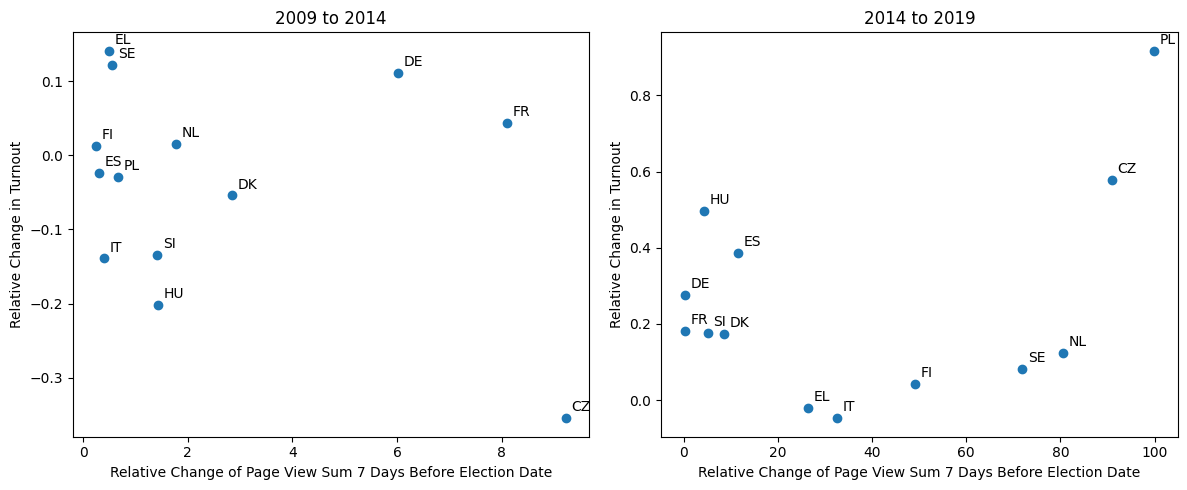

In [26]:
save_path = "./report/fig/scatter.png"
plot_scatter(change_df_2009, change_df_2014, save_path=save_path)